In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel("./data.xlsx")
df.set_index("Record ID",drop=False,inplace=True)
df.head(2)

,Record ID,Aircraft: Type,Airport: Name,Altitude bin,Aircraft: Make/Model,Wildlife: Number struck,Wildlife: Number Struck Actual,Effect: Impact to flight,FlightDate,Effect: Indicated Damage,...,Remains of wildlife sent to Smithsonian,Remarks,Wildlife: Size,Conditions: Sky,Wildlife: Species,Pilot warned of birds or wildlife?,Cost: Total $,Feet above ground,Number of people injured,Is Aircraft Large?
Record ID,,,,,,,,,,,,,,,,,,,,,
202152,202152,Airplane,LAGUARDIA NY,> 1000 ft,B-737-400,Over 100,859,Engine Shut Down,2000-11-23,Caused damage,...,False,FLT 753. PILOT REPTD A HUNDRED BIRDS ON UNKN T...,Medium,No Cloud,Unknown bird - medium,N,30736,1500.0,0,Yes
208159,208159,Airplane,DALLAS/FORT WORTH INTL ARPT,< 1000 ft,MD-80,Over 100,424,NaN,2001-07-25,Caused damage,...,False,102 CARCASSES FOUND. 1 LDG LIGHT ON NOSE GEAR ...,Small,Some Cloud,Rock pigeon,Y,0,0.0,0,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25558 entries, 202152 to 319593
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Record ID                                25558 non-null  int64         
 1   Aircraft: Type                           25429 non-null  object        
 2   Airport: Name                            25429 non-null  object        
 3   Altitude bin                             25429 non-null  object        
 4   Aircraft: Make/Model                     25558 non-null  object        
 5   Wildlife: Number struck                  25429 non-null  object        
 6   Wildlife: Number Struck Actual           25558 non-null  int64         
 7   Effect: Impact to flight                 2078 non-null   object        
 8   FlightDate                               25429 non-null  datetime64[ns]
 9   Effect: Indicated Damage              

In [5]:
df["Aircraft: Make/Model"] = df["Aircraft: Make/Model"].astype("category")
df["Airport: Name"] = df["Airport: Name"].astype("category")
df["Conditions: Sky"] = df["Conditions: Sky"].astype("category")
df["Conditions: Precipitation"] = df["Conditions: Precipitation"].astype("category")
df["Is Aircraft Large?"] =df["Is Aircraft Large?"].map({"Yes": True, "No": False})
df["Wildlife: Size"] = df["Wildlife: Size"].astype("category")
df["Effect: Indicated Damage"] =df["Effect: Indicated Damage"].astype('category')
df["Effect: Impact to flight"] = df["Effect: Impact to flight"].astype('category')
df["Aircraft: Type"] = df["Aircraft: Type"].astype("category")
df["Pilot warned of birds or wildlife?"] = df["Pilot warned of birds or wildlife?"].map({"Y": True, "N": False, np.nan: np.nan})
df["Origin State"] = df["Origin State"].astype("category")
df["Effect: Indicated Damage"] = df["Effect: Indicated Damage"].map({"Caused damage": True, "No damage": False}).astype("boolean")


In [6]:
df.drop_duplicates(inplace=True)
df.shape

(25558, 26)

In [7]:
def get_null_list():
    nulls = {}

    for i in df.columns:
        nulls[i] = df[df[i].isna()].shape[0]

    return nulls


In [8]:
df["Wildlife: Number struck"] = df["Wildlife: Number struck"].mask(df["Wildlife: Number Struck Actual"] > 100, "Over 100")
df["Wildlife: Number struck"] = df["Wildlife: Number struck"].mask((df["Wildlife: Number Struck Actual"] <= 100) & ( df["Wildlife: Number Struck Actual"] >= 11), "11 to 100")
df["Wildlife: Number struck"] = df["Wildlife: Number struck"].mask((df["Wildlife: Number Struck Actual"] >= 2) & (df["Wildlife: Number Struck Actual"] <= 10), "2 to 10")
df["Wildlife: Number struck"] = df["Wildlife: Number struck"].mask(df["Wildlife: Number Struck Actual"] == 1, 1)
df["Is Aircraft Large?"] = df["Is Aircraft Large?"].mask(df["Aircraft: Number of engines?"] == 1, "No")


In [9]:
df = df.dropna(how="all", axis=0)
df = df.dropna(subset=["Feet above ground"], how="any", axis=0)

df = df.dropna(subset=[
    'Aircraft: Number of engines?',
    "Effect: Impact to flight",
    "Conditions: Precipitation"
],axis=0, how="all")

cond1 = df['Aircraft: Number of engines?']

df[
    (df['Aircraft: Number of engines?'].isna()) &
    (df["Effect: Impact to flight"].isna()) &
    (df["Conditions: Precipitation"].isna())
].shape

df = df.dropna(subset=["Aircraft: Number of engines?"], how="any", axis=0)

df["Pilot warned of birds or wildlife?"] = df["Pilot warned of birds or wildlife?"].astype("boolean")
df = df.drop(labels=['Effect: Impact to flight', "Conditions: Precipitation", "Remarks"], axis = 1)

In [10]:
get_null_list()

{'Record ID': 0,
 'Aircraft: Type': 0,
 'Airport: Name': 0,
 'Altitude bin': 0,
 'Aircraft: Make/Model': 0,
 'Wildlife: Number struck': 0,
 'Wildlife: Number Struck Actual': 0,
 'FlightDate': 0,
 'Effect: Indicated Damage': 0,
 'Aircraft: Number of engines?': 0,
 'Aircraft: Airline/Operator': 0,
 'Origin State': 448,
 'When: Phase of flight': 0,
 'Remains of wildlife collected?': 0,
 'Remains of wildlife sent to Smithsonian': 0,
 'Wildlife: Size': 0,
 'Conditions: Sky': 0,
 'Wildlife: Species': 0,
 'Pilot warned of birds or wildlife?': 0,
 'Cost: Total $': 0,
 'Feet above ground': 0,
 'Number of people injured': 0,
 'Is Aircraft Large?': 0}

In [11]:
from collections import Counter

tt =  'Aircraft: Airline/Operator'
x = df[df["Origin State"].isna()][tt].to_list()
x = set(x)

for i in x:
    l = df[(~df["Origin State"].isna()) & (df[tt] == i)]["Origin State"].to_list()
    if len(l) > 0:    
        df["Origin State"] = df["Origin State"].mask((df[tt] == i) & (df["Origin State"].isna()), Counter(l).most_common()[0][0])


In [12]:
df = df.dropna(axis=0, subset=["Origin State"])

In [13]:
df["Altitude bin"] = df["Altitude bin"].astype("category")
df["Is Aircraft Large?"] = df["Is Aircraft Large?"].map(
    {"No": False, True: True, False: False})
df["Wildlife: Species"] = df["Wildlife: Species"].astype('category')
df["Aircraft: Airline/Operator"] = df["Aircraft: Airline/Operator"].astype(
    "category")
df["When: Phase of flight"] = df["When: Phase of flight"].astype("category")
df["Wildlife: Number struck"] = df["Wildlife: Number struck"].map(
    {"Over 100": "Over 100", "2 to 10": "2 to 10", "11 to 100": "11 to 100", 1: "1"}).astype("category")
df["Aircraft: Number of engines?"] = df["Aircraft: Number of engines?"].map(
    {"C": "C", 1: "1", 2: "2", 3: "3", 4: "4"}).astype("category")

df["Remains of wildlife collected?"] = df["Remains of wildlife collected?"].astype("boolean")
df["Remains of wildlife sent to Smithsonian"] = df["Remains of wildlife sent to Smithsonian"].astype("boolean")

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25193 entries, 202152 to 319593
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Record ID                                25193 non-null  int64         
 1   Aircraft: Type                           25193 non-null  category      
 2   Airport: Name                            25193 non-null  category      
 3   Altitude bin                             25193 non-null  category      
 4   Aircraft: Make/Model                     25193 non-null  category      
 5   Wildlife: Number struck                  25193 non-null  category      
 6   Wildlife: Number Struck Actual           25193 non-null  int64         
 7   FlightDate                               25193 non-null  datetime64[ns]
 8   Effect: Indicated Damage                 25193 non-null  boolean       
 9   Aircraft: Number of engines?          

### Number of bird strikes

1. Year
2. Phase of flight
3. Wildlife: Size, Condition: Sky


In [15]:
df['year']   = df['FlightDate'].dt.year

min_year, max_year = df['year'].min(), df['year'].max()
year_groups_list = list(range(min_year, max_year+2,2))
df['year_groups'] = pd.cut(df['year'],year_groups_list,include_lowest=True)
df['year_groups'] = df['year_groups'].map(lambda x: f'{x.left}-{x.right}')

# df['year_groups'] = df['year_groups'].astype(object)


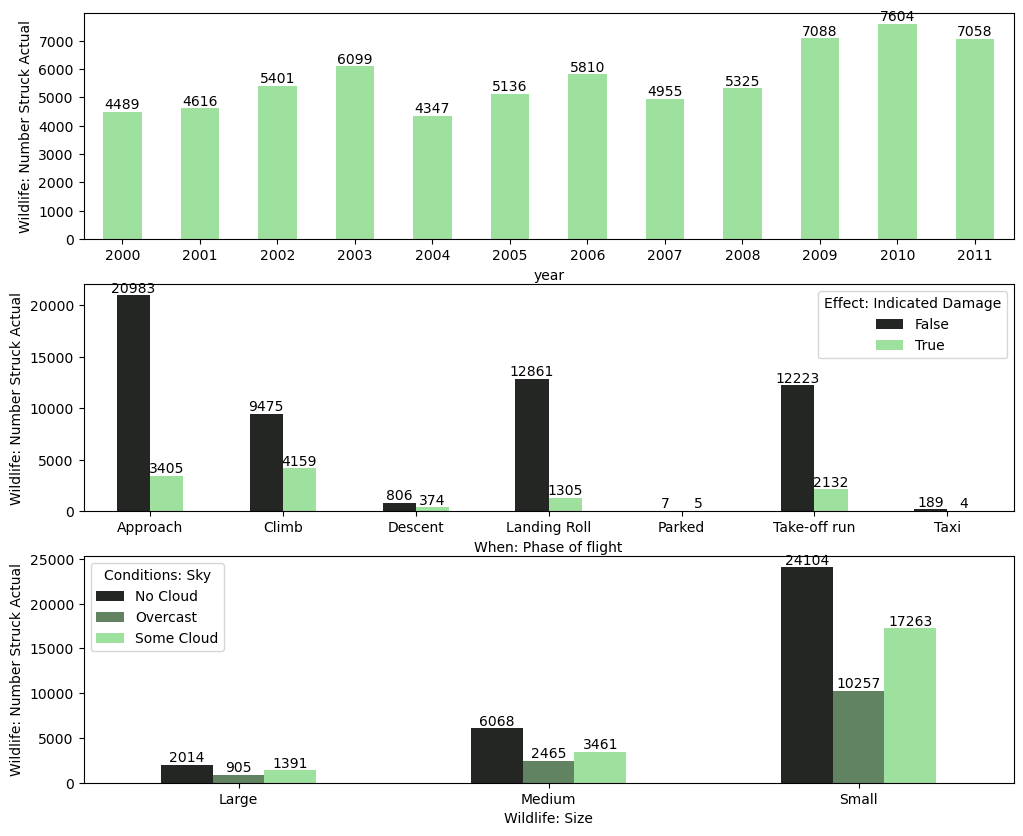

In [16]:
df['year'] = df["FlightDate"].dt.year

fig, ax = plt.subplots(3, 1, figsize=(12, 10))

ax1 = ax[0]
sns.barplot(
    df,
    x="year",
    y="Wildlife: Number Struck Actual",
    estimator="sum",
    errorbar=None,
    saturation=0.7,
    width=0.5,
    color="lightgreen",
    ax=ax1
)
ax1.bar_label(ax1.containers[0])

ax2 = ax[1]

sns.barplot(
    df, x="When: Phase of flight",
    hue="Effect: Indicated Damage",
    y="Wildlife: Number Struck Actual",
    estimator="sum",
    errorbar=None,
    width=0.5,
    saturation=0.7,
    palette="dark:lightgreen",
    ax=ax2
)
ax2.bar_label(ax2.containers[0])
ax2.bar_label(ax2.containers[1])


ax3 = ax[2]
sns.barplot(
    df,
    x="Wildlife: Size",
    y="Wildlife: Number Struck Actual",
    estimator="sum",
    hue="Conditions: Sky",
    errorbar=None,
    saturation=0.7,
    width=0.5,
    palette="dark:lightgreen",
    
    ax=ax3
)

ax3.bar_label(ax3.containers[0])
ax3.bar_label(ax3.containers[1])
ax3.bar_label(ax3.containers[2])


plt.show()

df.drop(labels=['year'], axis=1, inplace=True)

In [ ]:
sns.barplot(
    df, x="When: Phase of flight",
    hue="Effect: Indicated Damage",
    y="Wildlife: Number Struck Actual",
    estimator="sum",
    errorbar=None,
    width=0.5,
    saturation=0.7,
    palette="dark:lightgreen",
    ax=ax2
)

<Axes: xlabel='Conditions: Sky', ylabel='Wildlife: Number Struck Actual'>

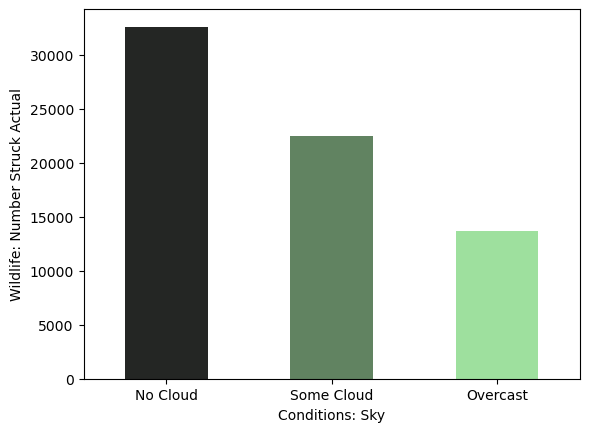

In [3]:
sns.barplot(
    df,
    x="Conditions: Sky",
    y="Wildlife: Number Struck Actual",
    estimator="sum",
    hue="Conditions: Sky",
    errorbar=None,
    saturation=0.7,
    width=0.5,
    palette="dark:lightgreen"
)


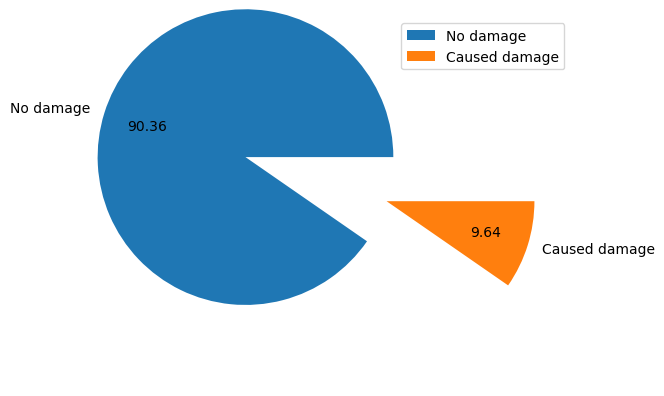

In [17]:
# Effect: Indicated Damage
pivot = df.groupby(by=["Effect: Indicated Damage"]).count()["Record ID"]

labels = list(map(lambda x: "Caused damage" if x else "No damage", pivot.keys()))
vals = list(pivot)

plt.pie(x=vals, labels=labels, explode=[1, 0], autopct=lambda x: f'{x:.2f}',pctdistance=0.7)
plt.legend()

plt.show()

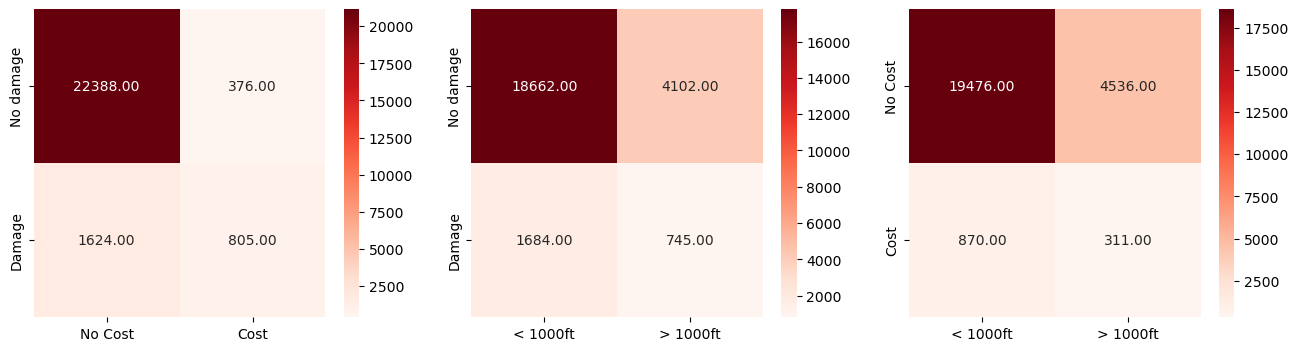

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))


df["Any Cost?"] = df["Cost: Total $"].map(lambda x: False if x == 0 else True)

pivot = df.groupby(by=[
    "Effect: Indicated Damage",
    "Any Cost?"
]).count()["Record ID"]

sns.heatmap(pivot.to_numpy().reshape((2, 2)),
            robust=True,
            yticklabels=["No damage", "Damage"],
            xticklabels=["No Cost", "Cost"],
            cmap="Reds",
            annot=True,
            fmt='.2f',
            ax=ax[0]
            )

pivot = df.groupby(by=[
    "Effect: Indicated Damage",
    "Altitude bin",
], observed=True).count()["Record ID"]
sns.heatmap(pivot.to_numpy().reshape((2, 2)),
            robust=True,
            xticklabels=["< 1000ft", "> 1000ft"],
            yticklabels=["No damage", "Damage"],
            cmap="Reds",
            annot=True,
            fmt='.2f', ax=ax[1],

            )

pivot = df.groupby(by=[
    "Any Cost?",
    "Altitude bin",
], observed=True).count()["Record ID"]
sns.heatmap(
    pivot.to_numpy().reshape((2, 2)),
    robust=True,
    xticklabels=["< 1000ft", "> 1000ft"],
    yticklabels=["No Cost", "Cost"],
    cmap="Reds",
    annot=True,
    fmt='.2f',
    ax=ax[2]
)

plt.show()

In [19]:

def iqr_cleaning(data: np.ndarray | pd.Series, percentile=0):
    """
    IQR cleaning function.

    Args:
        data: NumPy array to be cleaned.
        percentile: The percentile used to define outliers (default 1.5). A higher percentile removes less data.

    Returns:
        A NumPy array with outliers removed.
    """
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - (percentile * iqr)
    upper_bound = q3 + (percentile * iqr)
    
    return data[(data >= lower_bound) & (data <= upper_bound)]

def grouped_mean(group, value):
    return df.groupby(by=[group], observed=True)[value].apply(lambda x: iqr_cleaning(x).mean())

In [20]:
print(grouped_mean("When: Phase of flight", "Feet above ground"), end="\n\n")
print(grouped_mean("Effect: Indicated Damage", "Cost: Total $"), end="\n\n")
print(grouped_mean("Altitude bin", "Cost: Total $"), end="\n\n")


When: Phase of flight
Approach         552.075255
Climb            337.305601
Descent         5511.194030
Landing Roll       0.000000
Parked             0.000000
Take-off run       0.000000
Taxi               0.000000
Name: Feet above ground, dtype: float64

Effect: Indicated Damage
False      0.0
True     189.0
Name: Cost: Total $, dtype: float64

Altitude bin
< 1000 ft    0.0
> 1000 ft    0.0
Name: Cost: Total $, dtype: float64



In [21]:
data_schema = {}
for i in df.columns:
    data_schema[i] = i

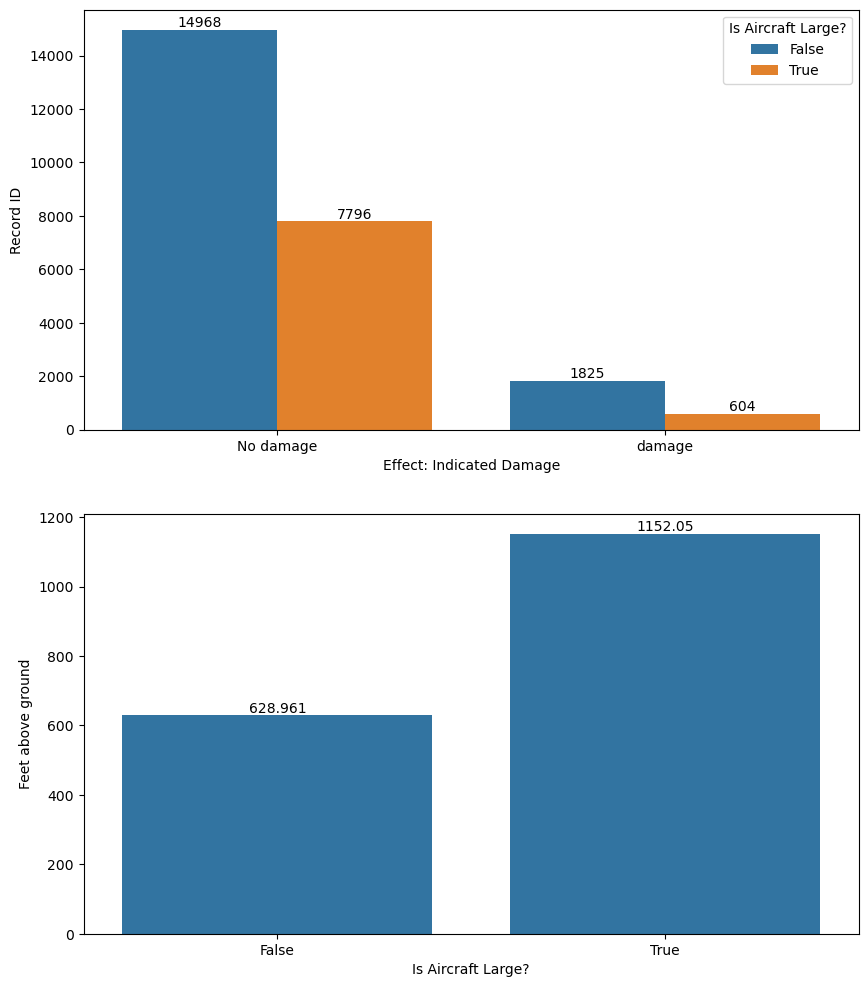

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(10,12))
ax = sns.barplot(
    df,
    x=data_schema["Effect: Indicated Damage"],
    hue=data_schema["Is Aircraft Large?"],
    y=data_schema["Record ID"],
    estimator="count",
    dodge=True,
    errorbar=None,
    ax=axs[0]
)

ax.set_xticks([False, True], ["No damage", "damage"])
ax.bar_label(ax.containers[0]) # type: ignore
ax.bar_label(ax.containers[1]) # type: ignore

ax = sns.barplot(
    df,
    x=data_schema["Is Aircraft Large?"],
    y=data_schema["Feet above ground"],
    estimator="mean",
    dodge=True,
    errorbar=None,
    ax=axs[1]
)

ax.bar_label(ax.containers[0]) # type: ignore


plt.show()

In [23]:
class DataSchema:
    record_id = 'Record ID'
    aircraft_type = "Aircraft: Type"
    airport_name = "Airport: Name"
    
    altitude_bin = "Altitude bin"
    aircraft_make_model = "Aircraft: Make/Model"
    wildlife_nbr_struck = "Wildlife: Number struck"

    wildlife_nbr_struck_actual = "Wildlife: Number Struck Actual"
    aircraft_nbr_engines = "Aircraft: Number of engines?"
    aircraft_airline_operator = "Aircraft: Airline/Operator"
    
    flight_date = "FlightDate"
    effect_indicated_damage = "Effect: Indicated Damage"
    origin_state = "Origin State"

    when_phase_of_flight = "When: Phase of flight"
    remains_of_wildlife_collected = "Remains of wildlife collected?"
    remains_of_wildlife_sent_to_smithsonian = "Remains of wildlife sent to Smithsonian"

    wildlife_size = "Wildlife: Size"
    cost_total = "Cost: Total $"
    wildlife_species = "Wildlife: Species"
    
    conditions_sky = "Conditions: Sky"
    pilot_warned_of_birds_or_wildlife = "Pilot warned of birds or wildlife"
    feet_above_ground = "Feet above ground"

    nbr_of_people_injured = "Number of people injured"
    is_aircraft_large = "Is Aircraft Large?"


In [24]:
grouped_mean(DataSchema.aircraft_nbr_engines, DataSchema.feet_above_ground)

Aircraft: Number of engines?
1      85.190578
2      85.348864
3     181.350711
4      96.211604
C    4000.000000
Name: Feet above ground, dtype: float64

In [25]:
grouped_mean(DataSchema.wildlife_size, DataSchema.feet_above_ground)

Wildlife: Size
Large     278.341265
Medium    289.977035
Small      48.598102
Name: Feet above ground, dtype: float64

In [26]:
costs =df[(df[DataSchema.effect_indicated_damage] == True) & 
   (df["Any Cost?"] == True) & (df[DataSchema.is_aircraft_large]==False)][DataSchema.cost_total].to_numpy()


In [27]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Histogram(x=costs, histnorm='probability',nbinsx=75)])
fig

In [28]:
i = df[(df[DataSchema.effect_indicated_damage] == True) & (df["Any Cost?"] == True)]["Pilot warned of birds or wildlife?"].to_list()
k = Counter(i)

fig = go.Figure(data=[go.Pie(values=tuple(k.values()),labels=tuple(k.keys()),title="Is Pilot warned?")])
fig

In [29]:
heights = df[(df[DataSchema.effect_indicated_damage] == True) &
             (df["Any Cost?"] == True)][DataSchema.feet_above_ground].to_numpy()

fig = go.Figure(data=go.Histogram(x=heights,histnorm="probability", nbinsx=50))

fig.update_layout(title="Feet Above Ground")
fig

In [30]:
k = df[(df[DataSchema.effect_indicated_damage]) & (
    df["Any Cost?"] == True)][DataSchema.aircraft_nbr_engines]
k = Counter(k)

fig = go.Figure(data=go.Pie(values=tuple(k.values()),
                            labels=tuple(k.keys())
                            ))

fig.update_layout(
    title="Number of engines"
)
fig

In [31]:
from plotly.subplots import make_subplots

x = df[(df[DataSchema.effect_indicated_damage]) & (df["Any Cost?"] == True)]
costs = x[DataSchema.cost_total].to_numpy()
heights = x[DataSchema.feet_above_ground].to_numpy()

fig = make_subplots(rows=1, cols=2, subplot_titles=(
    "Height to Strikes", "Height to Cost"))

trace_one = px.scatter(x, y=DataSchema.wildlife_nbr_struck_actual,
                       x=DataSchema.feet_above_ground).data[0]
trace_two = px.scatter(x, y=DataSchema.cost_total, x=DataSchema.feet_above_ground, color_discrete_sequence=["green"],
                       ).data[0]

fig.add_trace(trace=trace_one, row=1, col=1)
fig.add_trace(trace=trace_two, row=1, col=2)
fig.update_xaxes(row=1, col=1, title_text="Feet Above Ground")
fig.update_xaxes(row=1, col=2, title_text="Feet Above Ground")
fig.update_yaxes(row=1, col=1, title_text="No. of Strikes")
fig.update_yaxes(row=1, col=2, title_text="Total Cost")

fig.show()

In [54]:
# pivot = df[(df[DataSchema.effect_indicated_damage])& (df["Any Cost?"] == True)]

df["altitude_groups"] = pd.cut(x=df[DataSchema.feet_above_ground],bins=10,right=True)

df["altitude_groups"].replace(pd.Series(map(lambda x: f'{x.left}-{x.right}',
                        pd.cut(x=df[DataSchema.feet_above_ground], bins=10,right=True))))

df["altitude_groups"].unique()

[(-18.0, 1800.0], (3600.0, 5400.0], (1800.0, 3600.0], (7200.0, 9000.0], (5400.0, 7200.0], (9000.0, 10800.0], (12600.0, 14400.0], (14400.0, 16200.0], (10800.0, 12600.0], (16200.0, 18000.0]]
Categories (10, interval[float64, right]): [(-18.0, 1800.0] < (1800.0, 3600.0] < (3600.0, 5400.0] < (5400.0, 7200.0] ... (10800.0, 12600.0] < (12600.0, 14400.0] < (14400.0, 16200.0] < (16200.0, 18000.0]]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25193 entries, 202152 to 319593
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Record ID                                25193 non-null  int64         
 1   Aircraft: Type                           25193 non-null  category      
 2   Airport: Name                            25193 non-null  category      
 3   Altitude bin                             25193 non-null  category      
 4   Aircraft: Make/Model                     25193 non-null  category      
 5   Wildlife: Number struck                  25193 non-null  category      
 6   Wildlife: Number Struck Actual           25193 non-null  int64         
 7   FlightDate                               25193 non-null  datetime64[ns]
 8   Effect: Indicated Damage                 25193 non-null  boolean       
 9   Aircraft: Number of engines?          

TypeError: 'NoneType' object is not subscriptable